In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, ElasticNetCV, LassoCV, SGDRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, RepeatedKFold, ShuffleSplit, GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../cleaned_data/clean_v5_fillednans.csv', delimiter=',')

In [3]:
corr = df.corr(method='spearman')
#_, ax = plt.subplots(figsize=(20,10)) 
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True, linewidth=0.5, ax=ax)

In [4]:
defaults = [
    'GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption',
    'Positive affect',
    'Negative affect'
]

discovered_params = [
    'Trust in government',
    'Health spending',
    'Internet access',
    'Home access to computers',
    'Average wage',
    'Poverty rate',
]

additional_params = [
    'Self-employment rate',
    'Households overcrowding',
]

Y = df[['Happiness index']].values
Y_bin = df[['Happy country']].values
X_default = df[[*defaults]].values
X_basis = df[[*defaults, *discovered_params]].values
X_extended = df[[*defaults, *discovered_params, *additional_params]].values
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_extended, Y, test_size=0.2, random_state=41)
X_train_bin, X_test_bin, Y_train_bin, Y_test_bin = train_test_split(X_extended, Y_bin, test_size=0.2, random_state=41)
regr_cols = ['name', 'Adj. R2', 'R2', 'RMSE']
class_cols = ['name', 'accuracy', 'recall', 'precision', 'f1']
regr_df = pd.DataFrame(columns=regr_cols)
class_df = pd.DataFrame(columns=class_cols)

<AxesSubplot:>

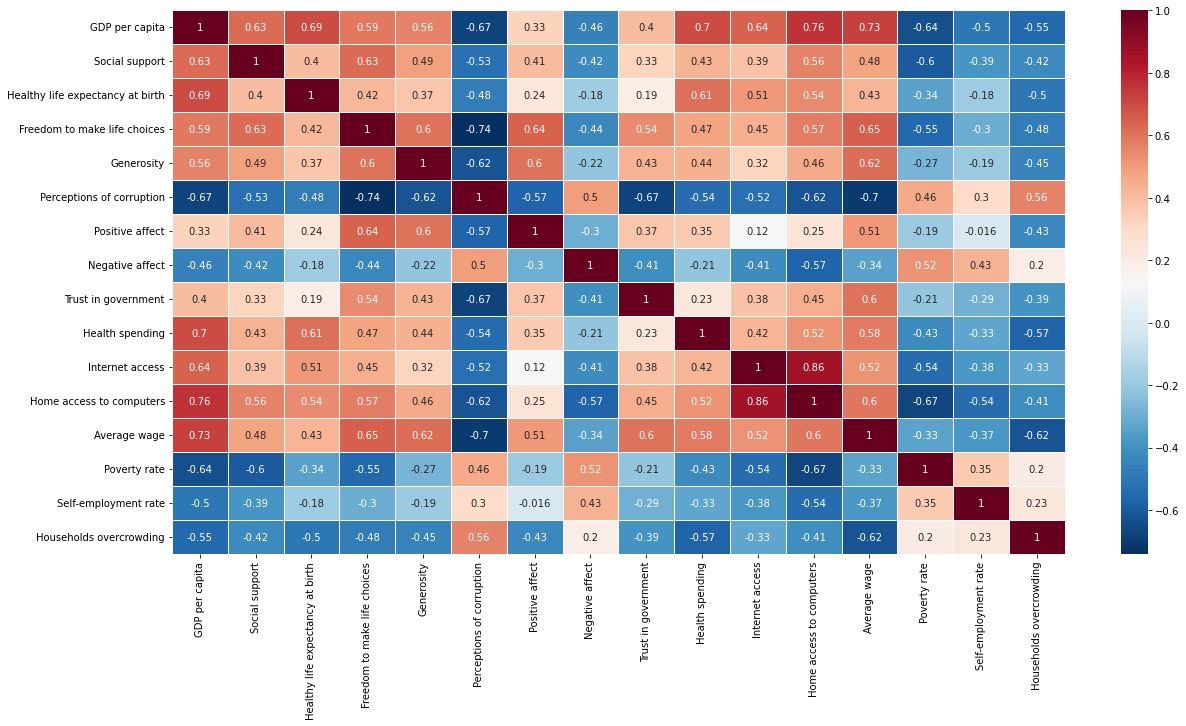

In [5]:
corr = df[[*defaults, *discovered_params, *additional_params]].corr(method='spearman')
_, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True, linewidth=0.5, ax=ax)

In [6]:
def train_linear(X, name):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)
    pipeline_linear = make_pipeline(StandardScaler(), LinearRegression())
    pipeline_linear.fit(X_train, Y_train)
    Y_pred_test = pipeline_linear.predict(X_test)
    insert_test_results(pipeline_linear, X_test, Y_test, name)
    return pipeline_linear
    
def train_classifier(X, name, linear=True):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_bin, test_size=0.2, random_state=41)
    pipline_logistic = make_pipeline(StandardScaler(), LogisticRegression()) #LogisticRegression(C=1, penalty='l1', solver='liblinear')
    pipline_logistic.fit(X_train, Y_train.ravel())
    insert_test_results(pipline_logistic, X_test, Y_test, name, linear)
    return pipline_logistic

def insert_test_results(model, xtest, ytest, name, regr=True):
    global regr_df
    global class_df
    test_score = model.score(xtest, ytest)
    ypred = model.predict(xtest)
    if regr:
        adj_r2 = round(1 - (1-test_score)*((len(xtest)-1)/(len(xtest)-xtest.shape[1]-1)), 5)
        rmse = metrics.mean_squared_error(ytest, ypred, squared=False)
        regr_df = pd.concat([regr_df, pd.DataFrame([[name, adj_r2, test_score, rmse]], columns=regr_cols)])
    else:
        recall = round(metrics.recall_score(ytest, ypred), 5)
        precision = round(metrics.precision_score(ytest, ypred), 5)
        f1 = round(metrics.f1_score(ytest, ypred), 5)
        class_df = pd.concat([class_df, pd.DataFrame([[name, test_score, recall, precision, f1]], columns=class_cols)])
    

In [7]:
# default parameters
model_def_lin = train_linear(X_default, 'LinReg-defaults')
model_def_log = train_classifier(X_default,'LogReg-defaults', False)

#discovered parameters
model_disc_lin = train_linear(X_basis, 'LinReg-disc')
model_disc_log = train_classifier(X_basis, 'LogReg-disc', False)

#discovered + additional parameters
model_ext_lin = train_linear(X_extended, 'LinReg-disc+add')
model_ext_log = train_classifier(X_extended, 'LogReg-disc+add', False)

display(regr_df)
display(class_df)

,name,Adj. R2,R2,RMSE
0,LinReg-defaults,0.70086,0.722617,0.448823
0,LinReg-disc,0.70015,0.738309,0.435943
0,LinReg-disc+add,0.70333,0.746479,0.429084


,name,accuracy,recall,precision,f1
0,LogReg-defaults,0.612613,0.73973,0.69231,0.71523
0,LogReg-disc,0.63964,0.75342,0.71429,0.73333
0,LogReg-disc+add,0.657658,0.73973,0.73973,0.73973


In [8]:
# CLASSIFICATION k-cross validation
warnings.filterwarnings("ignore")
parameters = {
    'logisticregression__penalty' : ['l1', 'l2'], 
    'logisticregression__C'       : np.logspace(-3, 10, 10),
    'logisticregression__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(model_ext_log,param_grid = parameters, scoring='f1', cv=cv)
clf.fit(X_train_bin, Y_train_bin)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([1.00000000e-03, 2.78255940e-02, 7.74263683e-01, 2.15443469e+01,
       5.99484250e+02, 1.66810054e+04, 4.64158883e+05, 1.29154967e+07,
       3.59381366e+08, 1.00000000e+10]),
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear']},
             scoring='f1')

In [9]:
print("Tuned Hyperparameters :", clf.best_params_)
insert_test_results(clf, X_test_bin, Y_test_bin, 'LogRes-disc+add-CV',False)

Tuned Hyperparameters : {'logisticregression__C': 0.027825594022071243, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}


In [10]:
# LINEAR k-cross validation
k_model = GridSearchCV(estimator = model_ext_lin, 
                        param_grid = {
                            'linearregression__fit_intercept': [True, False],
                            'linearregression__positive': [True, False]
                        }, 
                        scoring= 'r2', 
                        cv = cv)
k_model.fit(X_train, Y_train)
insert_test_results(k_model, X_test, Y_test, 'LinReg-disc+add-CV')

In [11]:
# RIDGE k-cross validation - Rather failed
ridge = make_pipeline(StandardScaler(), Ridge())
ridge.fit(X_train, Y_train)
insert_test_results(ridge, X_test, Y_test, 'Ridge')

param = {
    'ridge__fit_intercept':[True,False],
    'ridge__solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'ridge__alpha': [0.0015, 0.001, 0.002, 0.003]
    
}
k_model = GridSearchCV(estimator = ridge, 
                        param_grid = param,
                        scoring= 'r2', 
                        cv = cv,
                      )

k_model.fit(X_train, Y_train)
insert_test_results(k_model, X_test, Y_test, 'Ridge-CV')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


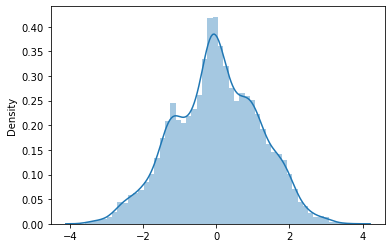

In [25]:
from sklearn.ensemble import RandomForestRegressor

basic_forest = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', RandomForestRegressor(verbose=1))
])
basic_forest.fit(X_train, Y_train)
insert_test_results(basic_forest, X_test, Y_test, 'RandomForestRegrressor')

forest_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
   # ('pca', PCA()),
    ('estimator', RandomForestRegressor())
])
forest_model.fit(X_train, Y_train)
y_hat = forest_model.predict(X_test)
sns.distplot(Y_test-y_hat)
insert_test_results(forest_model, X_test, Y_test, 'RandomForestRegrressor+PCA')

In [45]:
forest_CV = GridSearchCV(
        estimator=forest_model,
        param_grid={
            'estimator__max_depth': [10, 12, 15],
            'estimator__bootstrap': [True, False],
            'estimator__criterion': ['squared_error'],
            'estimator__max_features': ['auto', 'sqrt', 'log2'],
            'estimator__min_samples_leaf': [2, 3],
            'estimator__min_samples_split': [2, 3],
            'estimator__n_estimators': [150]
        },
        cv=cv,
        scoring='r2',
        #n_jobs=-1
        )
forest_CV.fit(X_train, Y_train)
#rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
# Perform K-Fold CV
#scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', RandomForestRegressor())]),
             param_grid={'estimator__bootstrap': [True, False],
                         'estimator__criterion': ['squared_error'],
                         'estimator__max_depth': [10, 12, 15],
                         'estimator__max_features': ['auto', 'sqrt', 'log2'],
                         'estimator__min_samples_leaf': [2, 3],
                         'estimator__min_samples_split': [2, 3],
                         'estimator__n_estimators': [150]},
             scoring='r2')

In [46]:
print(forest_CV.best_params_)
print(forest_CV.best_score_)
insert_test_results(forest_CV, X_test, Y_test, 'RandomForestRegressor+PCA-CV')

{'estimator__bootstrap': False, 'estimator__criterion': 'squared_error', 'estimator__max_depth': 12, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 3, 'estimator__n_estimators': 150}
0.9058288559161354


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_bin, Y_train_bin)
insert_test_results(gnb, X_test_bin, Y_test_bin, 'GaussianNB', False)

In [ ]:
nb_classifier = GaussianNB()

params = {'var_smoothing': np.logspace(0,-9, num=100)}
gnb_CV = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params, 
                 cv=cv, 
                 verbose=1, 
                 scoring='accuracy') 
gnb_CV.fit(X_train_bin, Y_train_bin)
insert_test_results(gnb, X_test_bin, Y_test_bin, 'GaussianNB-CV', False)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [47]:
display(regr_df)
display(class_df)

,name,Adj. R2,R2,RMSE
0,LinReg-defaults,0.70086,0.722617,0.448823
0,LinReg-disc,0.70015,0.738309,0.435943
0,LinReg-disc+add,0.70333,0.746479,0.429084
0,LinReg-disc+add-CV,0.70333,0.746479,0.429084
0,Ridge,0.70348,0.74661,0.428974
0,Ridge-CV,0.70332,0.746476,0.429087
0,RandomForestRegrressor,0.90745,0.920913,0.239655
0,RandomForestRegrressor+PCA,0.85173,0.873293,0.303345
0,RandomForestRegressor+PCA-CV,0.77064,0.803999,0.37728
0,RandomForestRegressor+PCA-CV,0.77185,0.805036,0.376281


,name,accuracy,recall,precision,f1
0,LogReg-defaults,0.612613,0.73973,0.69231,0.71523
0,LogReg-disc,0.63964,0.75342,0.71429,0.73333
0,LogReg-disc+add,0.657658,0.73973,0.73973,0.73973
0,LogRes-disc+add-CV,0.746835,0.80822,0.69412,0.74684
0,GaussianNB,0.585586,0.63014,0.70769,0.66667
0,GaussianNB-CV,0.585586,0.63014,0.70769,0.66667


In [ ]:
# savings best models
import pickle
model_regr = "../models/model_regr.pkl"
model_class = "../models/model_class.pkl"

with open(model_class, 'wb') as file:
    pickle.dump(clf, file)
    
with open(model_regr, 'wb') as file:
    pickle.dump(forest_CV, file)

NameError: name 'model' is not defined